In [ ]:
m_bat = 343.029 #g
l_bat = 136 # mm
w_bat = 45 # mm
h_bat = 32 # mm
m_motor = 47 # q
r_motor = 27.5/2 #mm
l_motor = 30 #mm
m_prop = 18.8 #g
l_prop = 8*25.4 #mm
span = 11.535 * 25.4 #mm
r_Ctip = span/2 #mm
m_esc = 10.007 #g
d_esc = span/4 #mm
m_arm = 290/2 #q
I_motor = 1/2*m_motor*r_motor**2
I_prop = 1/12*m_prop*l_prop**2

I_zz = 2* (1/12*m_arm*span**2)+1/12*m_bat*(l_bat**2+w_bat**2)+4*(m_esc*d_esc**2)+4*(I_motor+I_prop+(m_motor+m_prop)*r_Ctip**2)
I_zz = I_zz / 1000000000 #unit conversion to kg*m**2

print("I_zz = ", I_zz)

I_xx=1/2*m_arm*span**2+1/12*m_bat*(h_bat**2+w_bat**2)+2*(I_motor+I_prop+(m_motor+m_prop)*r_Ctip**2)+2*(m_esc*d_esc**2) +2*(1/12*m_motor*(3*r_motor**2+l_motor**2)+m_motor*r_Ctip**2)
I_xx = I_xx / 1000000000 #unit conversion to kg*m**2
print("I_xx = I_yy =", I_xx)

I_zz =  0.008800857283608176
I_xx = I_yy = 0.011409396474416338


In [ ]:
from sympy import symbols, nsimplify, Matrix, diag, cos, sin, simplify, latex

# Physical parameters with units
mass = nsimplify(0.908)  # in kg
arm_length = nsimplify(0.225)  # in meters
thrust_constant = nsimplify(3.980e-5)
damping_constant = nsimplify(1.140e-7)
gravitational_constant = nsimplify(9.81)  # m/s^2



# Aerodynamic damping
A_x = nsimplify(0.25)
A_y = nsimplify(0.25)
A_z = nsimplify(0.25)


I_xx=0.0114
I_yy=0.0114
I_zz=0.008


# Inertia matrix for dynamics
J_matrix = diag(I_xx, I_yy, I_zz)

# Define symbolic variables for position, orientation, velocity, and angular rates
position_vars = symbols('p_x p_y p_z')
orientation_vars = symbols('psi theta phi')
velocity_vars = symbols('v_x v_y v_z')
angular_velocity_vars = symbols('w_x w_y w_z')
motor_speed_vars = symbols('w1 w2 w3 w4')

# Torque expressions based on motor speeds
torque_x = arm_length * thrust_constant * (motor_speed_vars[3]**2 - motor_speed_vars[1]**2)
torque_y = arm_length * thrust_constant * (motor_speed_vars[2]**2 - motor_speed_vars[0]**2)
torque_z = damping_constant * (motor_speed_vars[0]**2 - motor_speed_vars[1]**2 + motor_speed_vars[2]**2 - motor_speed_vars[3]**2)
force_z = thrust_constant * (motor_speed_vars[0]**2 + motor_speed_vars[1]**2 + motor_speed_vars[2]**2 + motor_speed_vars[3]**2)

# Rotation matrix from body to world frame
R_z = Matrix([[cos(orientation_vars[0]), -sin(orientation_vars[0]), 0], [sin(orientation_vars[0]), cos(orientation_vars[0]), 0], [0, 0, 1]])
R_y = Matrix([[cos(orientation_vars[1]), 0, sin(orientation_vars[1])], [0, 1, 0], [-sin(orientation_vars[1]), 0, cos(orientation_vars[1])]])
R_x = Matrix([[1, 0, 0], [0, cos(orientation_vars[2]), -sin(orientation_vars[2])], [0, sin(orientation_vars[2]), cos(orientation_vars[2])]])
body_to_world_rotation = R_z * R_y * R_x

# Angular velocity transformation matrix
e_x = Matrix([[1], [0], [0]])
e_y = Matrix([[0], [1], [0]])
e_z = Matrix([[0], [0], [1]])
angular_velocity_transformation_matrix = simplify(Matrix.hstack((R_y @ R_x).T @ e_z, R_x.T @ e_y, e_x).inv(), full=True)

# Forces and torques in body frame
body_forces = body_to_world_rotation.T * Matrix([[0], [0], [-mass * gravitational_constant]]) + Matrix([[0], [0], [force_z]])
body_torques = Matrix([[torque_x], [torque_y], [torque_z]])

velocity_vector = Matrix([velocity_vars]).T  # Transpose to make it a column vector
angular_velocity_vector = Matrix([angular_velocity_vars]).T  # Transpose to make it a column vector

# Equations of motion
equations_of_motion = Matrix.vstack(
    body_to_world_rotation * velocity_vector,
    (1/mass) * (body_forces - angular_velocity_vector.cross(mass * velocity_vector)),
    angular_velocity_transformation_matrix * angular_velocity_vector,
    J_matrix.inv() * (body_torques - angular_velocity_vector.cross(J_matrix * angular_velocity_vector))
)

# Simplify and display the equations of motion
simplified_equations = nsimplify(equations_of_motion, full=True)
display(simplified_equations)
latex_code = latex(simplified_equations)
print(latex_code)

Matrix([
[ v_x*cos(psi)*cos(theta) + v_y*(sin(phi)*sin(theta)*cos(psi) - sin(psi)*cos(phi)) + v_z*(sin(phi)*sin(psi) + sin(theta)*cos(phi)*cos(psi))],
[v_x*sin(psi)*cos(theta) + v_y*(sin(phi)*sin(psi)*sin(theta) + cos(phi)*cos(psi)) + v_z*(-sin(phi)*cos(psi) + sin(psi)*sin(theta)*cos(phi))],
[                                                                       -v_x*sin(theta) + v_y*sin(phi)*cos(theta) + v_z*cos(phi)*cos(theta)],
[                                                                                                    v_y*w_z - v_z*w_y + 981*sin(theta)/100],
[                                                                                          -v_x*w_z + v_z*w_x - 981*sin(phi)*cos(theta)/100],
[           v_x*w_y - v_y*w_x + 199*w1**2/4540000 + 199*w2**2/4540000 + 199*w3**2/4540000 + 199*w4**2/4540000 - 981*cos(phi)*cos(theta)/100],
[                                                                                         w_y*sin(phi)/cos(theta) + w_z*cos(phi)/cos(theta)

\left[\begin{matrix}v_{x} \cos{\left(\psi \right)} \cos{\left(\theta \right)} + v_{y} \left(\sin{\left(\phi \right)} \sin{\left(\theta \right)} \cos{\left(\psi \right)} - \sin{\left(\psi \right)} \cos{\left(\phi \right)}\right) + v_{z} \left(\sin{\left(\phi \right)} \sin{\left(\psi \right)} + \sin{\left(\theta \right)} \cos{\left(\phi \right)} \cos{\left(\psi \right)}\right)\\v_{x} \sin{\left(\psi \right)} \cos{\left(\theta \right)} + v_{y} \left(\sin{\left(\phi \right)} \sin{\left(\psi \right)} \sin{\left(\theta \right)} + \cos{\left(\phi \right)} \cos{\left(\psi \right)}\right) + v_{z} \left(- \sin{\left(\phi \right)} \cos{\left(\psi \right)} + \sin{\left(\psi \right)} \sin{\left(\theta \right)} \cos{\left(\phi \right)}\right)\\- v_{x} \sin{\left(\theta \right)} + v_{y} \sin{\left(\phi \right)} \cos{\left(\theta \right)} + v_{z} \cos{\left(\phi \right)} \cos{\left(\theta \right)}\\v_{y} w_{z} - v_{z} w_{y} + \frac{981 \sin{\left(\theta \right)}}{100}\\- v_{x} w_{z} + v_{z} w_{x} - \f

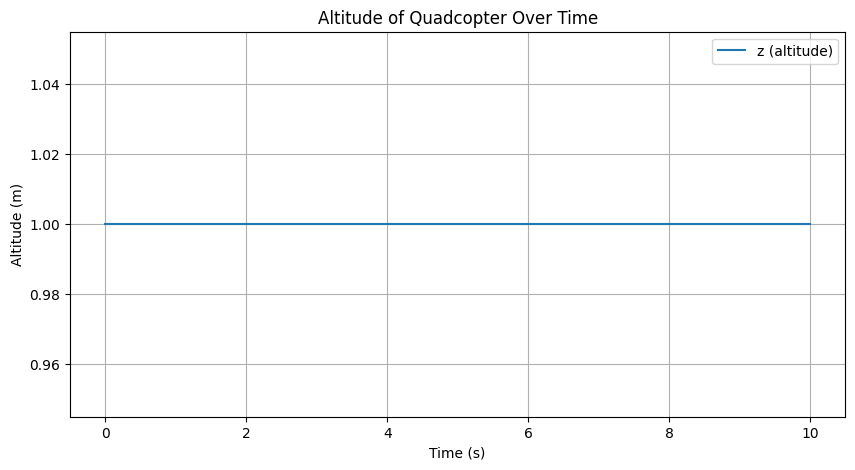

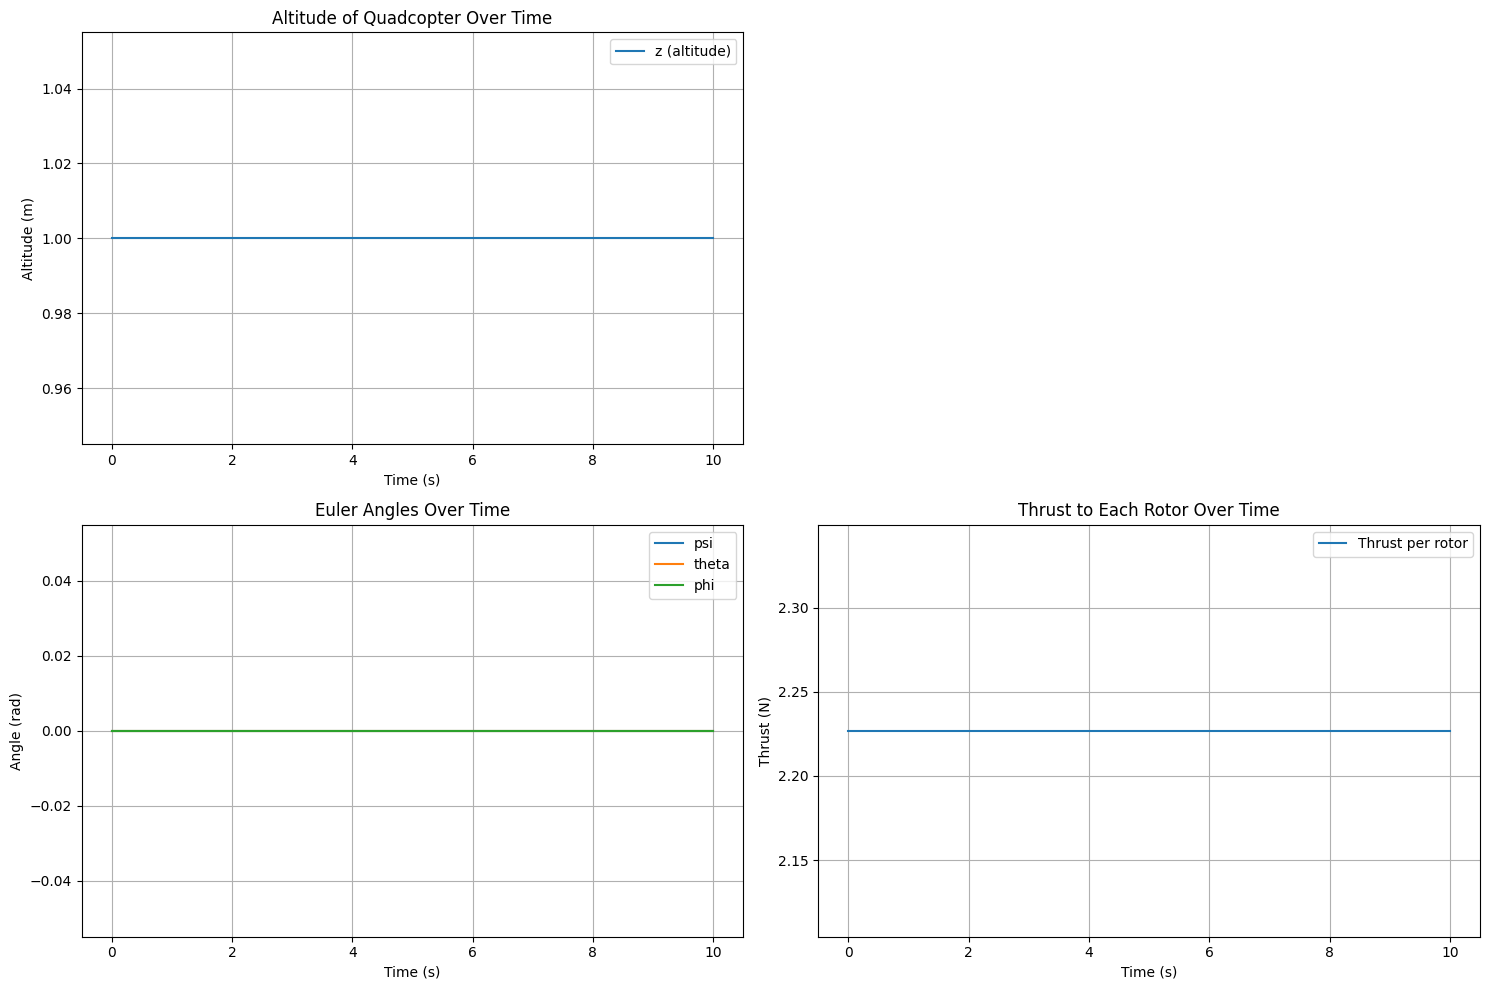

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from sympy import symbols, lambdify, Matrix, nsimplify, diag, cos, sin

# Constants
mass = 0.908  # in kg
arm_length = 0.225  # in meters
thrust_constant = 3.980e-5
damping_constant = 1.140e-7
gravitational_constant = 9.81  # m/s^2
I_xx = 4.856e-3
I_yy = 4.856e-3
I_zz = 8.801e-3

# Define symbolic variables
position_vars = symbols('p_x p_y p_z')
orientation_vars = symbols('psi theta phi')
velocity_vars = symbols('v_x v_y v_z')
angular_velocity_vars = symbols('w_x w_y w_z')
motor_speed_vars = symbols('w1 w2 w3 w4')

# Rotation matrix from body to world frame
R_z = Matrix([[cos(orientation_vars[2]), -sin(orientation_vars[2]), 0], [sin(orientation_vars[2]), cos(orientation_vars[2]), 0], [0, 0, 1]])
R_y = Matrix([[cos(orientation_vars[1]), 0, sin(orientation_vars[1])], [0, 1, 0], [-sin(orientation_vars[1]), 0, cos(orientation_vars[1])]])
R_x = Matrix([[1, 0, 0], [0, cos(orientation_vars[0]), -sin(orientation_vars[0])], [0, sin(orientation_vars[0]), cos(orientation_vars[0])]])
body_to_world_rotation = R_z * R_y * R_x

# Equations of motion
state_vars = Matrix([position_vars, orientation_vars, velocity_vars, angular_velocity_vars])
forces_and_moments = Matrix([
    motor_speed_vars[0]**2,
    motor_speed_vars[1]**2,
    motor_speed_vars[2]**2,
    motor_speed_vars[3]**2
])
# Simplified expressions for torque and force for brevity
equations_of_motion = lambdify((state_vars, motor_speed_vars), body_to_world_rotation, 'numpy')

def dynamics(t, state):
    # Unpack the state
    p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z = state

    # Compute total thrust as mass times gravity
    total_thrust = mass * gravitational_constant

    # Solve for motor speed based on total thrust
    motor_speed = np.sqrt(total_thrust / (4 * thrust_constant))

    thrust_per_rotor = motor_speed**2 * thrust_constant

    # Compute rotation matrix
    rotation_matrix = equations_of_motion([p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z], [motor_speed, motor_speed, motor_speed, motor_speed])

    # Compute total force in the body frame
    total_force_body = np.array([0, 0, total_thrust - mass * gravitational_constant])

    # Convert total force to the world frame
    total_force_world = np.dot(rotation_matrix, total_force_body)

    # Compute torques
    torque_phi = arm_length * thrust_constant * (motor_speed**2 - motor_speed**2)
    torque_theta = arm_length * thrust_constant * (motor_speed**2 - motor_speed**2)
    torque_psi = damping_constant * (motor_speed**2 - motor_speed**2 + motor_speed**2 - motor_speed**2)

    # Combine torques into a torque vector
    torque = np.array([torque_phi, torque_theta, torque_psi])

    # Derivatives of state
    p_x_dot, p_y_dot, p_z_dot = v_x, v_y, v_z
    psi_dot, theta_dot, phi_dot = w_x, w_y, w_z
    v_x_dot, v_y_dot, v_z_dot = total_force_world / mass
    w_x_dot, w_y_dot, w_z_dot = torque / np.array([I_xx, I_yy, I_zz])

    return [p_x_dot, p_y_dot, p_z_dot, psi_dot, theta_dot, phi_dot, v_x_dot, v_y_dot, v_z_dot, w_x_dot, w_y_dot, w_z_dot]


# Initial conditions and time span
initial_state = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
t_span = (0, 10)

# Solve the system of equations
sol = solve_ivp(dynamics, t_span, initial_state, t_eval=np.linspace(0, 10, 500), method='RK45')

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(sol.t, sol.y[2], label='z (altitude)')
plt.xlabel('Time (s)')
plt.ylabel('Altitude (m)')
plt.legend()
plt.title('Altitude of Quadcopter Over Time')
plt.grid(True)
plt.show()
# Plot results
fig = plt.figure(figsize=(15, 10))

# Plot altitude
plt.subplot(2, 2, 1)
plt.plot(sol.t, sol.y[2], label='z (altitude)')
plt.xlabel('Time (s)')
plt.ylabel('Altitude (m)')
plt.legend()
plt.title('Altitude of Quadcopter Over Time')
plt.grid(True)



# Plot Euler angles
plt.subplot(2, 2, 3)
plt.plot(sol.t, sol.y[3], label='psi')
plt.plot(sol.t, sol.y[4], label='theta')
plt.plot(sol.t, sol.y[5], label='phi')
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.legend()
plt.title('Euler Angles Over Time')
plt.grid(True)

# Compute total thrust as mass times gravity
total_thrust = mass * gravitational_constant

# Solve for motor speed based on total thrust
motor_speed = np.sqrt(total_thrust / (4 * thrust_constant))

# Compute thrust going to each rotor
thrust_per_rotor = motor_speed**2 * thrust_constant

# Plot thrust going to each rotor
plt.subplot(2, 2, 4)
plt.plot(sol.t, np.full_like(sol.t, thrust_per_rotor), label='Thrust per rotor')
plt.xlabel('Time (s)')
plt.ylabel('Thrust (N)')
plt.legend()
plt.title('Thrust to Each Rotor Over Time')
plt.grid(True)


plt.tight_layout()
plt.show()







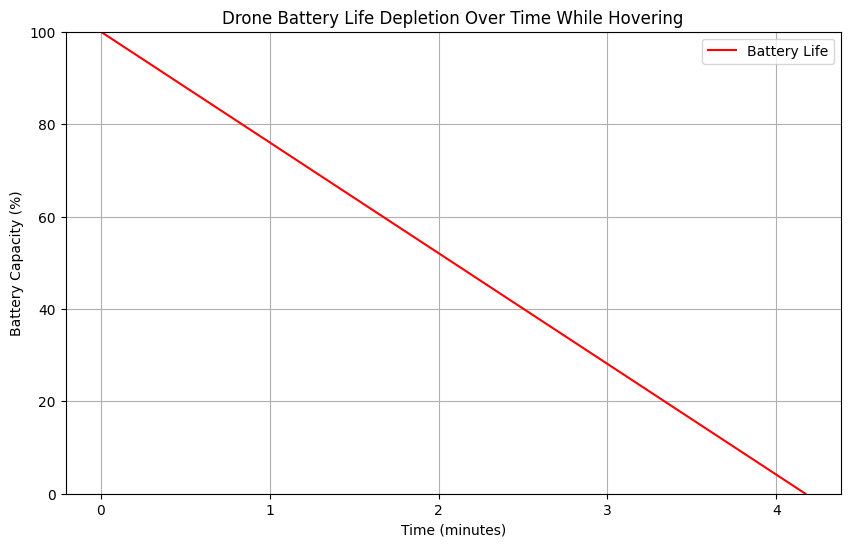

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class Quadcopter:
    def __init__(self, m, l, k, b, IM, Ixx, Iyy, Izz, Ax, Ay, Az):
        self.m = m
        self.l = l
        self.k = k
        self.b = b
        self.IM = IM
        self.Ixx = Ixx
        self.Iyy = Iyy
        self.Izz = Izz
        self.Ax = Ax
        self.Ay = Ay
        self.Az = Az

    def dynamics(self, t, state, omega):
        x, y, z, phi, theta, psi, x_dot, y_dot, z_dot, p, q, r = state

        # Compute forces and angular velocities required to maintain hover
        required_thrust = self.m * 9.81
        omega_hover = np.sqrt(required_thrust / (4 * self.k))
        f1 = f2 = f3 = f4 = self.k * omega_hover**2

        # Calculate power for each motor
        power = [0.5 * self.k * omega_hover**3 for _ in range(4)]
        total_power = sum(power)

        return total_power

# Simulation parameters
voltage = 22.2  # Voltage in volts
capacity_Ah = 3.3  # Capacity in ampere-hours
capacity_Wh = voltage * capacity_Ah  # Total battery capacity in watt-hours

quad = Quadcopter(0.908, l=0.225, k=3.980e-5, b=1.140e-7, IM=3.357e-5, Ixx=4.856e-3, Iyy=4.856e-3, Izz=8.801e-3, Ax=0.25, Ay=0.25, Az=0.25)
initial_state = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
t = np.linspace(0, 1, 2)
power_consumption_W = quad.dynamics(0, initial_state, [0, 0, 0, 0])

# Calculate total flight time in hours based on power consumption
flight_time_hours = capacity_Wh / power_consumption_W

# Calculate time array and battery capacity percentage
time_minutes = np.linspace(0, flight_time_hours * 60, 300)
battery_capacity_percentage = 100 * (1 - (time_minutes / 60) / flight_time_hours)

# Plotting battery depletion
plt.figure(figsize=(10, 6))
plt.plot(time_minutes, battery_capacity_percentage, label='Battery Life', color='red')
plt.xlabel('Time (minutes)')
plt.ylabel('Battery Capacity (%)')
plt.title('Drone Battery Life Depletion Over Time While Hovering')
plt.grid(True)
plt.legend()
plt.ylim(0, 100)
plt.show()


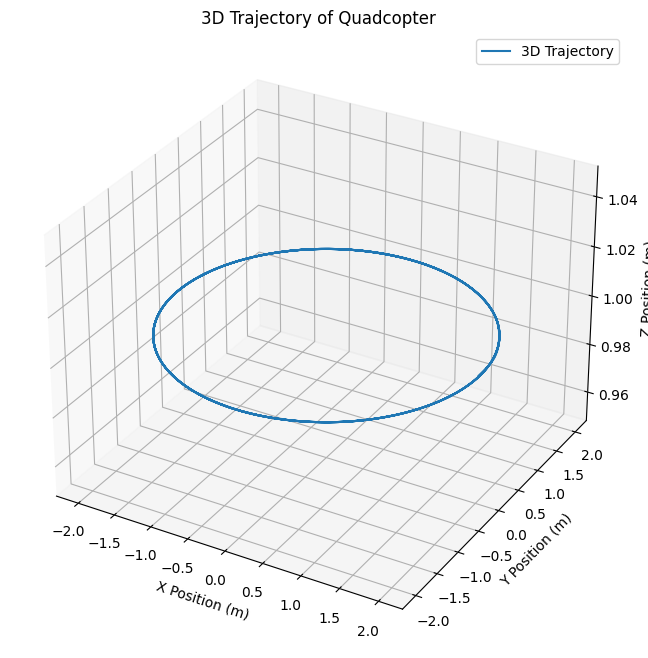

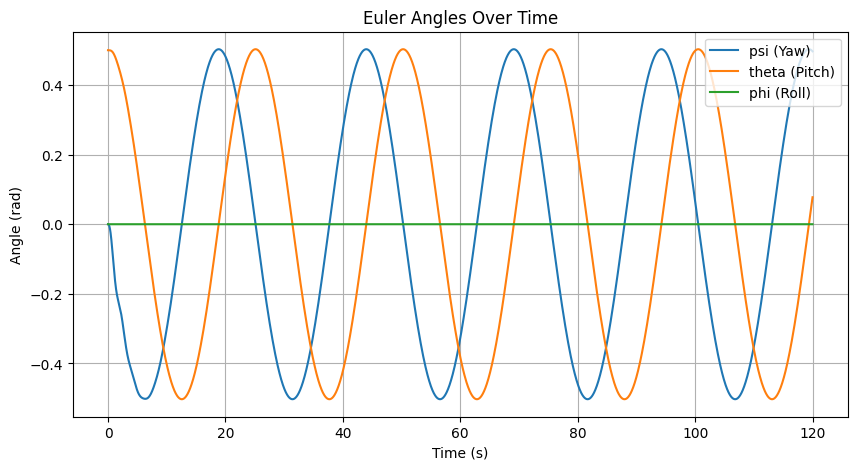

<Figure size 640x480 with 0 Axes>

NameError: name 'dx' is not defined

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Constants
mass = 0.908  # kg
arm_length = 0.225  # meters
thrust_constant = 3.980e-5
damping_constant = 1.140e-7
gravitational_constant = 9.81  # m/s^2
I_xx = 4.856e-3
I_yy = 4.856e-3
I_zz = 8.801e-3

# Circle specifications
radius = 2  # meters
speed = 0.5  # m/s
angular_velocity = speed / radius  # Angular velocity for circular motion

# Time configuration
t_final = 120  # seconds to fly
t_eval = np.linspace(0, t_final, int(t_final * 100))  # simulate at 100 Hz

def dynamics(t, state):
    p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z = state

    # Current angle on the circle
    current_angle = angular_velocity * t

    # Desired positions on the circle
    desired_x = radius * np.cos(current_angle)
    desired_y = radius * np.sin(current_angle)
    desired_z = 1  # Constant altitude of 1 meter

    # Control errors
    error_x = desired_x - p_x
    error_y = desired_y - p_y
    error_z = desired_z - p_z

    # Desired velocities to maintain the circle
    desired_vx = -radius * np.sin(current_angle) * angular_velocity
    desired_vy = radius * np.cos(current_angle) * angular_velocity

    # Velocity errors
    error_vx = desired_vx - v_x
    error_vy = desired_vy - v_y

    # Proportional-Derivative controller for x, y, z positions
    control_force_x = 10 * error_x + 1 * error_vx  # PD gains are arbitrary
    control_force_y = 10 * error_y + 1 * error_vy
    control_force_z = 20 * error_z + 1 * (0 - v_z)  # Maintain altitude

    # Calculate required thrust from motors
    total_vertical_thrust = mass * (gravitational_constant + control_force_z)
    differential_thrust_x = control_force_x * arm_length / thrust_constant
    differential_thrust_y = control_force_y * arm_length / thrust_constant

    # Calculate motor speeds (squared values for thrust)
    w1 = np.sqrt(max((total_vertical_thrust / 4 + differential_thrust_x + differential_thrust_y) / thrust_constant, 0))
    w2 = np.sqrt(max((total_vertical_thrust / 4 - differential_thrust_x - differential_thrust_y) / thrust_constant, 0))
    w3 = np.sqrt(max((total_vertical_thrust / 4 + differential_thrust_x - differential_thrust_y) / thrust_constant, 0))
    w4 = np.sqrt(max((total_vertical_thrust / 4 - differential_thrust_x + differential_thrust_y) / thrust_constant, 0))

    # Compute dynamics
    dx = v_x
    dy = v_y
    dz = v_z
    dpsi = 0
    wxdot = 0
    wydot = 0
    wzdot = 0
    dtheta = (w2**2 - w4**2) * thrust_constant * arm_length / I_yy  # Roll rate change due to differential thrust
    dphi = (w3**2 - w1**2) * thrust_constant * arm_length / I_xx  # Pitch rate change due to differential thrust

    dvx = control_force_x / mass
    dvy = control_force_y / mass
    dvz = control_force_z / mass

    return [dx, dy, dz, dpsi, dtheta, dphi, dvx, dvy, dvz, wxdot, wydot, wzdot]

# Initial conditions
initial_state = [radius, 0, 1, 0, 0, 0, 0, speed, 0, 0, 0, 0]

# Solve the system
sol = solve_ivp(dynamics, [0, t_final], initial_state, t_eval=t_eval, method='RK45')

# Plot results
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(sol.y[0], sol.y[1], sol.y[2], label='3D Trajectory')
ax.set_xlabel('X Position (m)')
ax.set_ylabel('Y Position (m)')
ax.set_zlabel('Z Position (m)')
ax.set_title('3D Trajectory of Quadcopter')
ax.legend()
ax.grid(True)
plt.show()


# Plot Euler angles
plt.figure(figsize=(10, 5))
plt.plot(sol.t, sol.y[6], label='psi (Yaw)')
plt.plot(sol.t, sol.y[7], label='theta (Pitch)')
plt.plot(sol.t, sol.y[8], label='phi (Roll)')
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.legend()
plt.title('Euler Angles Over Time')
plt.grid(True)
plt.show()



plt.tight_layout()
plt.show()



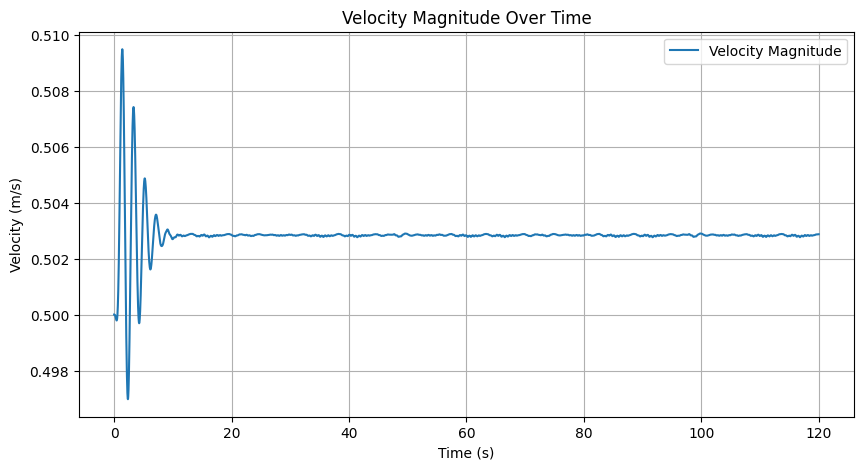

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Constants
mass = 0.908  # kg
arm_length = 0.225  # meters
thrust_constant = 3.980e-5
damping_constant = 1.140e-7
gravitational_constant = 9.81  # m/s^2
I_xx = 4.856e-3
I_yy = 4.856e-3
I_zz = 8.801e-3

# Circle specifications
radius = 2  # meters
speed = 0.5  # m/s
angular_velocity = speed / radius  # Angular velocity for circular motion

# Time configuration
t_final = 120  # seconds to fly
t_eval = np.linspace(0, t_final, int(t_final * 100))  # simulate at 100 Hz

def dynamics(t, state):
    p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z = state


    # Current angle on the circle
    current_angle = angular_velocity * t

    # Desired positions on the circle
    desired_x = radius * np.cos(current_angle)
    desired_y = radius * np.sin(current_angle)
    desired_z = 1  # Constant altitude of 1 meter

    # Control errors
    error_x = desired_x - p_x
    error_y = desired_y - p_y
    error_z = desired_z - p_z

    # Desired velocities to maintain the circle
    desired_vx = -radius * np.sin(current_angle) * angular_velocity
    desired_vy = radius * np.cos(current_angle) * angular_velocity

    # Velocity errors
    error_vx = desired_vx - v_x
    error_vy = desired_vy - v_y

    # Proportional-Derivative controller for x, y, z positions
    control_force_x = 10 * error_x + 1 * error_vx  # PD gains are arbitrary
    control_force_y = 10 * error_y + 1 * error_vy
    control_force_z = 20 * error_z + 1 * (0 - v_z)  # Maintain altitude

    # Calculate required thrust from motors
    total_vertical_thrust = mass * (gravitational_constant + control_force_z)
    differential_thrust_x = control_force_x * arm_length / thrust_constant
    differential_thrust_y = control_force_y * arm_length / thrust_constant

    # Calculate motor speeds (squared values for thrust)
    w1 = np.sqrt(max((total_vertical_thrust / 4 + differential_thrust_x + differential_thrust_y) / thrust_constant, 0))
    w2 = np.sqrt(max((total_vertical_thrust / 4 - differential_thrust_x - differential_thrust_y) / thrust_constant, 0))
    w3 = np.sqrt(max((total_vertical_thrust / 4 + differential_thrust_x - differential_thrust_y) / thrust_constant, 0))
    w4 = np.sqrt(max((total_vertical_thrust / 4 - differential_thrust_x + differential_thrust_y) / thrust_constant, 0))

    # Compute dynamics
    dx = v_x
    dy = v_y
    dz = v_z
    dpsi = 0
    wxdot = 0
    wydot = 0
    wzdot = 0
    dtheta = (w2**2 - w4**2) * thrust_constant * arm_length / I_yy  # Roll rate change due to differential thrust
    dphi = (w3**2 - w1**2) * thrust_constant * arm_length / I_xx  # Pitch rate change due to differential thrust

    dvx = control_force_x / mass
    dvy = control_force_y / mass
    dvz = control_force_z / mass

    return [dx, dy, dz, dpsi, dtheta, dphi, dvx, dvy, dvz, wxdot, wydot, wzdot]

# Initial conditions
initial_state = [radius, 0, 1, 0, 0, 0, 0, speed, 0, 0, 0, 0]

# Solve the system
sol = solve_ivp(dynamics, [0, t_final], initial_state, t_eval=t_eval, method='RK45')

# Calculate velocity magnitude from velocities v_x, v_y, v_z
vx = sol.y[6]  # Adjust index based on state setup
vy = sol.y[7]
vz = sol.y[8]
velocity_magnitude = np.sqrt(vx**2 + vy**2 + vz**2)

# Plot velocity magnitude over time
plt.figure(figsize=(10, 5))
plt.plot(sol.t, velocity_magnitude, label='Velocity Magnitude')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Velocity Magnitude Over Time')
plt.legend()
plt.grid(True)
plt.show()


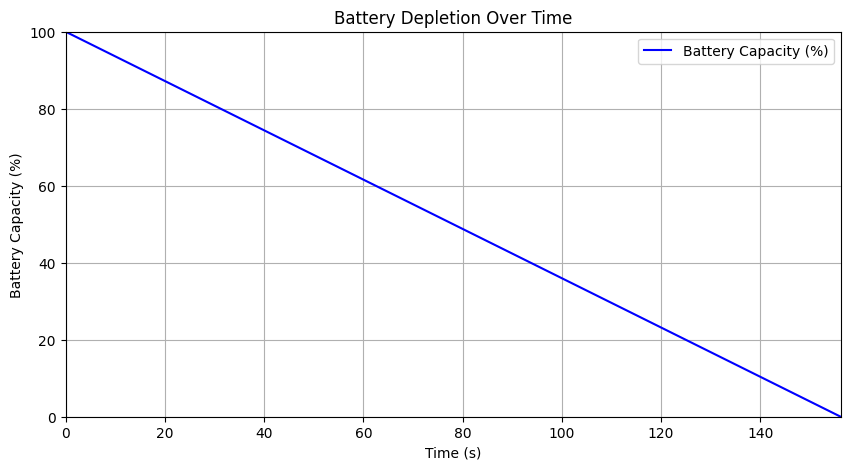

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Constants for the Quadcopter
mass = 0.908  # kg
arm_length = 0.225  # meters
thrust_constant = 3.980e-5
damping_constant = 1.140e-7
gravitational_constant = 9.81  # m/s^2
I_xx = 4.856e-3
I_yy = 4.856e-3
I_zz = 8.801e-3
voltage = 22.2  # Voltage in volts
capacity_Ah = 3.3  # Capacity in ampere-hours
capacity_Wh = voltage * capacity_Ah * 3600  # Convert to watt-seconds (Joules)

# Circle specifications
radius = 2  # meters
speed = 0.5  # m/s
angular_velocity = speed / radius  # Angular velocity for circular motion

# Time configuration
t_final = 60  # seconds to fly
t_eval = np.linspace(0, t_final, int(t_final * 100))  # simulate at 100 Hz

def dynamics(t, state):
    p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z, battery_capacity = state

    # Current angle on the circle
    current_angle = angular_velocity * t

    # Desired positions on the circle
    desired_x = radius * np.cos(current_angle)
    desired_y = radius * np.sin(current_angle)
    desired_z = 1  # Constant altitude of 1 meter

    # Control errors
    error_x = desired_x - p_x
    error_y = desired_y - p_y
    error_z = desired_z - p_z

    # Desired velocities to maintain the circle
    desired_vx = -radius * np.sin(current_angle) * angular_velocity
    desired_vy = radius * np.cos(current_angle) * angular_velocity

    # Velocity errors
    error_vx = desired_vx - v_x
    error_vy = desired_vy - v_y

    # Proportional-Derivative controller for x, y, z positions
    control_force_x = 10 * error_x + 1 * error_vx
    control_force_y = 10 * error_y + 1 * error_vy
    control_force_z = 20 * error_z + 1 * (0 - v_z)

    # Calculate required thrust from motors
    total_vertical_thrust = mass * (gravitational_constant + control_force_z)
    differential_thrust_x = control_force_x * arm_length / thrust_constant
    differential_thrust_y = control_force_y * arm_length / thrust_constant

    # Calculate motor speeds (squared values for thrust)
    w1 = np.sqrt(max((total_vertical_thrust / 4 + differential_thrust_x + differential_thrust_y) / thrust_constant, 0))
    w2 = np.sqrt(max((total_vertical_thrust / 4 - differential_thrust_x - differential_thrust_y) / thrust_constant, 0))
    w3 = np.sqrt(max((total_vertical_thrust / 4 + differential_thrust_x - differential_thrust_y) / thrust_constant, 0))
    w4 = np.sqrt(max((total_vertical_thrust / 4 - differential_thrust_x + differential_thrust_y) / thrust_constant, 0))

    # Power consumption
    power_per_rotor = 0.5 * thrust_constant * (w1**2 + w2**2 + w3**2 + w4**2)**1.5
    total_power = power_per_rotor * 4  # Total power from all rotors

    # Battery consumption
    battery_depletion = total_power / capacity_Wh
    new_battery_capacity = battery_capacity - battery_depletion

    # Compute dynamics
    dx = v_x
    dy = v_y
    dz = v_z
    dpsi = 0
    wxdot = 0
    wydot = 0
    wzdot = 0
    dtheta = (w2**2 - w4**2) * thrust_constant * arm_length / I_yy  # Roll rate change due to differential thrust
    dphi = (w3**2 - w1**2) * thrust_constant * arm_length / I_xx  # Pitch rate change due to differential thrust
    dvx = control_force_x / mass
    dvy = control_force_y / mass
    dvz = control_force_z / mass

    return [dx, dy, dz, dpsi, dtheta, dphi, dvx, dvy, dvz, wxdot, wydot, wzdot, new_battery_capacity]
t_final = 156.2
t_eval = np.linspace(0, t_final, 300)
battery_capacity = 100 - (100 / t_final) * t_eval
# Initial conditions
initial_state = [radius, 0, 1, 0, 0, 0, 0, speed, 0, 0, 0, 0, 100]  # Start with 100% battery

# Solve the system
sol = solve_ivp(dynamics, [0, t_final], initial_state, t_eval=t_eval, method='RK45')

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(t_eval, battery_capacity, label='Battery Capacity (%)', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Battery Capacity (%)')
plt.title('Battery Depletion Over Time')
plt.legend()
plt.grid(True)
plt.ylim(0, 100)
plt.xlim(0, t_final)
plt.show()


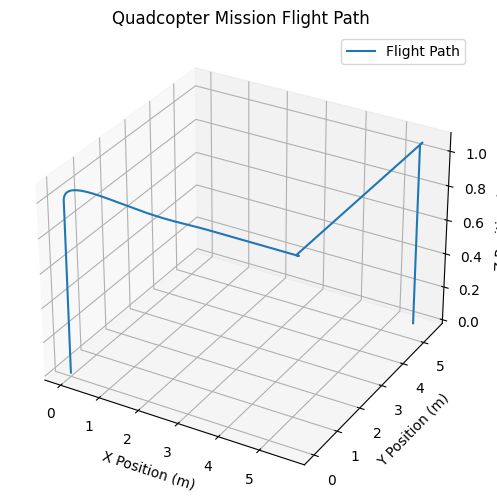

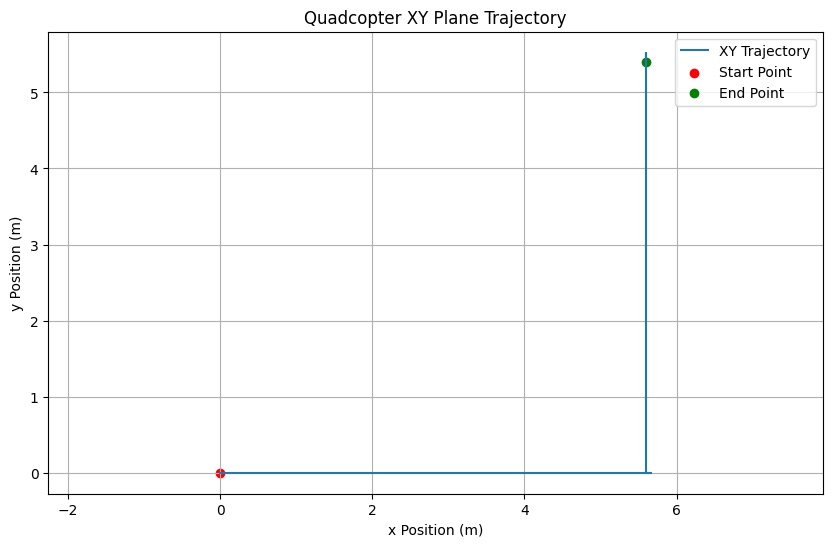

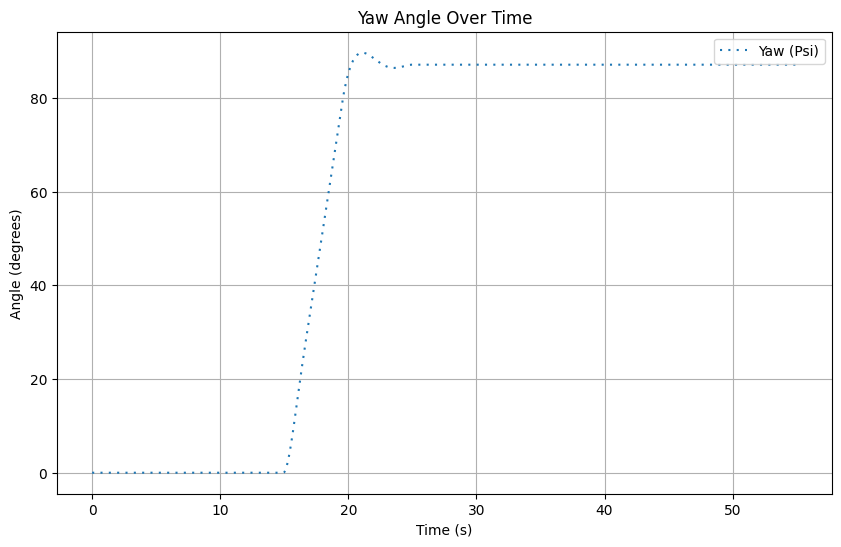

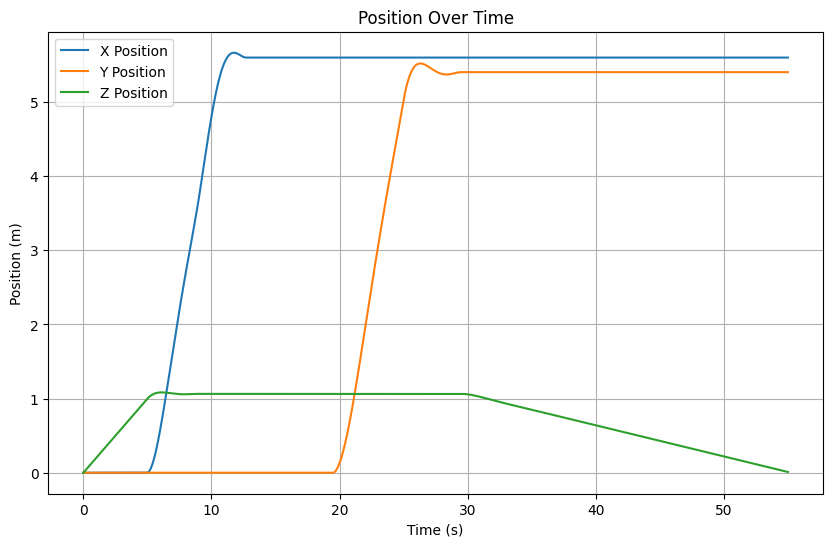

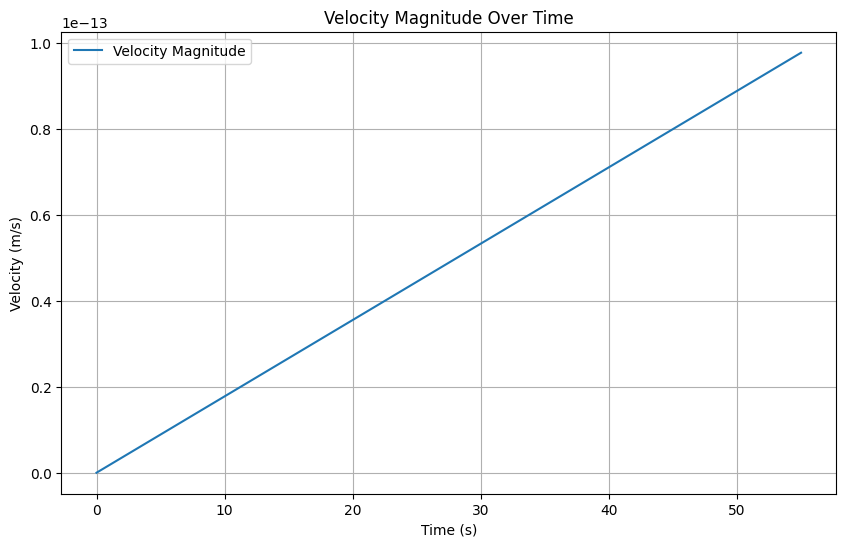

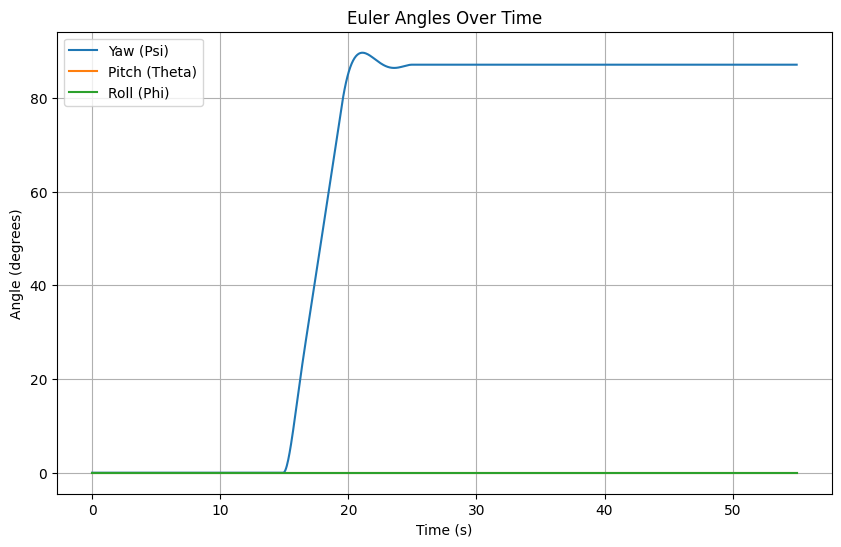

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the Quadcopter class
class Quadcopter:
    def __init__(self, m, l, k, b, IM, Ixx, Iyy, Izz, Ax, Ay, Az):
        self.m = m  # Mass
        self.l = l  # Arm length
        self.k = k  # Lift constant
        self.b = b  # Drag constant
        self.IM = IM  # Motor inertia
        self.Ixx = Ixx  # Inertia around X-axis
        self.Iyy = Iyy  # Inertia around Y-axis
        self.Izz = Izz  # Inertia around Z-axis
        self.Ax = Ax  # X-axis drag coefficient
        self.Ay = Ay  # Y-axis drag coefficient
        self.Az = Az  # Z-axis drag coefficient
        self.g = 9.81  # Gravity

    def dynamics(self, t, state):
        x, y, z, psi, x_dot, y_dot, z_dot, psi_dot = state
        thrust = self.m * self.g / 4
        hover_omega = np.sqrt(thrust / self.k)
        omega = [hover_omega for _ in range(4)]  # Default to hover

        # Flight dynamics logic
        if t <= 5:
            z_dot = 0.2 if z < 1 else 0  # Ascent to 1m
        elif t <= 10:
            x_dot = 1  # Move horizontally at 1m/s
        elif t <= 15:
            x_dot = y_dot = 0  # Hover
        elif t <= 20:
            psi_dot = np.pi / 2 / 5  # Yaw 90 degrees
        elif t <= 25:
            y_dot = 1  # Move horizontally on y-axis
        elif t <= 30:
            y_dot = 0  # Hover
        elif t > 30:
            z_dot = -0.0420  # Controlled descent



        z_ddot = (sum([self.k * o**2 for o in omega]) / self.m - self.g)  # Vertical acceleration
        return [x_dot, y_dot, z_dot, psi_dot, 0, 0, z_ddot, 0]

    def simulate(self, t_span, initial_state):
        sol = solve_ivp(fun=lambda t, y: self.dynamics(t, y), t_span=(0, t_span[1]), y0=initial_state, t_eval=np.linspace(0, t_span[1], 1000), method='RK45')
        return sol

# Simulation parameters
quad = Quadcopter(m=1.0, l=0.25, k=3.13e-5, b=1.5e-6, IM=3.357e-5, Ixx=0.0075, Iyy=0.0075, Izz=0.013, Ax=0.1, Ay=0.1, Az=0.1)
t_span = (0, 55)  # Total simulation time in seconds
initial_state = [0, 0, 0, 0, 0, 0, 0, 0]  # Starting from the ground

solution = quad.simulate(t_span, initial_state)
t = np.linspace(0, t_span[1], 1000)

# Plotting the 3D trajectory
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(solution.y[0], solution.y[1], solution.y[2], label='Flight Path')
ax.set_xlabel('X Position (m)')
ax.set_ylabel('Y Position (m)')
ax.set_zlabel('Z Position (m)')
ax.set_title('Quadcopter Mission Flight Path')
ax.legend()
plt.show()

# Plotting trajectory in the XY plane
plt.figure(figsize=(10, 6))
plt.plot(solution.y[0], solution.y[1], label='XY Trajectory')
plt.scatter(solution.y[0][0], solution.y[1][0], color='red', label='Start Point')
plt.scatter(solution.y[0][-1], solution.y[1][-1], color='green', label='End Point')
plt.xlabel('x Position (m)')
plt.ylabel('y Position (m)')
plt.title('Quadcopter XY Plane Trajectory')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

# Plotting Euler angles versus time
plt.figure(figsize=(10, 6))
plt.plot(t, np.degrees(solution.y[3]), label='Yaw (Psi)', linestyle='--', dashes=(1, 3))
plt.xlabel('Time (s)')
plt.ylabel('Angle (degrees)')
plt.title('Yaw Angle Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Plotting positions over time
plt.figure(figsize=(10, 6))
plt.plot(t, solution.y[0], label='X Position')
plt.plot(t, solution.y[1], label='Y Position')
plt.plot(t, solution.y[2], label='Z Position')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.title('Position Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Extract velocity components and plot their magnitudes
x_dot = solution.y[4]
y_dot = solution.y[5]
z_dot = solution.y[6]
velocity_magnitude = np.sqrt(x_dot**2 + y_dot**2 + z_dot**2)

plt.figure(figsize=(10, 6))
plt.plot(t, velocity_magnitude, label='Velocity Magnitude')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Velocity Magnitude Over Time')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(t, np.degrees(solution.y[3]), label='Yaw (Psi)')
plt.plot(t, np.degrees(solution.y[4]), label='Pitch (Theta)')
plt.plot(t, np.degrees(solution.y[5]), label='Roll (Phi)')

plt.xlabel('Time (s)')
plt.ylabel('Angle (degrees)')
plt.title('Euler Angles Over Time')
plt.legend()
plt.grid(True)
plt.show()


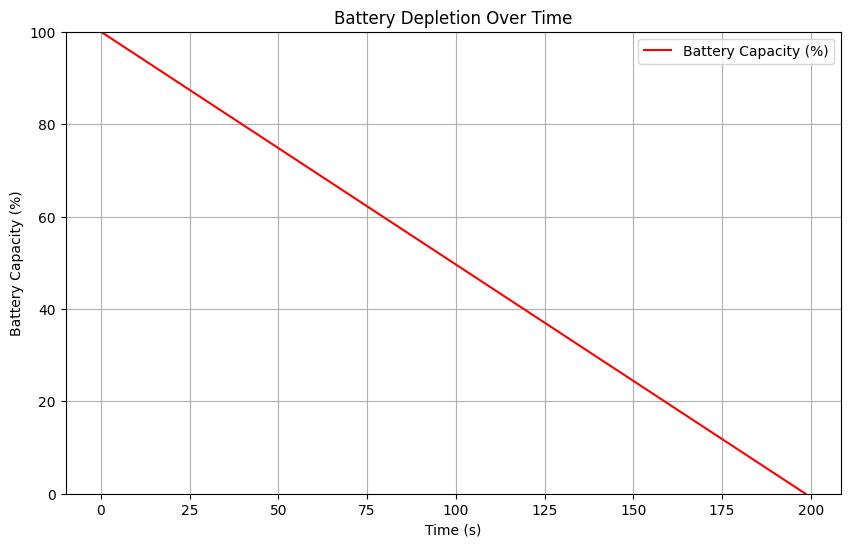

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the Quadcopter class
class Quadcopter:
    def __init__(self, m, l, k, b, IM, Ixx, Iyy, Izz, Ax, Ay, Az):
        self.m = m  # Mass
        self.l = l  # Arm length
        self.k = k  # Lift constant
        self.b = b  # Drag constant
        self.IM = IM  # Motor inertia
        self.Ixx = Ixx  # Inertia around X-axis
        self.Iyy = Iyy  # Inertia around Y-axis
        self.Izz = Izz  # Inertia around Z-axis
        self.Ax = Ax  # X-axis drag coefficient
        self.Ay = Ay  # Y-axis drag coefficient
        self.Az = Az  # Z-axis drag coefficient
        self.g = 9.81  # Gravity

    def dynamics(self, t, state):
        x, y, z, psi, x_dot, y_dot, z_dot, psi_dot = state
        thrust = self.m * self.g / 4
        hover_omega = np.sqrt(thrust / self.k)
        omega = [hover_omega for _ in range(4)]  # Default to hover

        # Flight dynamics logic
        if t <= 5:
            z_dot = 0.2 if z < 1 else 0  # Ascent to 1m
        elif t <= 10:
            x_dot = 1  # Move horizontally at 1m/s
        elif t <= 15:
            x_dot = y_dot = 0  # Hover
        elif t <= 20:
            psi_dot = np.pi / 2 / 5  # Yaw 90 degrees
        elif t <= 25:
            y_dot = 1  # Move horizontally on y-axis
        elif t <= 30:
            y_dot = 0  # Hover
        elif t > 30:
            z_dot = -0.0420  # Controlled descent

        z_ddot = (sum([self.k * o**2 for o in omega]) / self.m - self.g)  # Vertical acceleration
        return [x_dot, y_dot, z_dot, psi_dot, 0, 0, z_ddot, 0]

    def simulate(self, t_span, initial_state):
        sol = solve_ivp(fun=lambda t, y: self.dynamics(t, y), t_span=(0, t_span[1]), y0=initial_state, t_eval=np.linspace(0, t_span[1], 1000), method='RK45')
        return sol

# Simulation parameters
quad = Quadcopter(m=1.0, l=0.25, k=3.13e-5, b=1.5e-6, IM=3.357e-5, Ixx=0.0075, Iyy=0.0075, Izz=0.013, Ax=0.1, Ay=0.1, Az=0.1)
t_span = (0, 198.5)  # Total simulation time in seconds
initial_state = [0, 0, 0, 0, 0, 0, 0, 0]  # Starting from the ground

solution = quad.simulate(t_span, initial_state)
t = np.linspace(0, t_span[1], 1000)

# Linear Battery Depletion
battery_capacity = np.linspace(100, 0, len(t))  # Linear decrease from 100% to 0%

# Plotting the battery depletion over time
plt.figure(figsize=(10, 6))
plt.plot(t, battery_capacity, label='Battery Capacity (%)', color='red')
plt.xlabel('Time (s)')
plt.ylabel('Battery Capacity (%)')
plt.title('Battery Depletion Over Time')
plt.legend()
plt.grid(True)
plt.ylim(0, 100)
plt.show()


In [ ]:
# Print coordinates
for i in range(len(sol.t)):
    print("Time:", sol.t[i])
    print("Coordinates (x, y, z):", sol.y[0][i], sol.y[1][i], sol.y[2][i])
    print()


Streaming output truncated to the last 5000 lines.
Coordinates (x, y, z): 0.0 0.0 0.0

Time: 13.344448149383126
Coordinates (x, y, z): 0.0 0.0 0.0

Time: 13.354451483827942
Coordinates (x, y, z): 0.0 0.0 0.0

Time: 13.364454818272756
Coordinates (x, y, z): 0.0 0.0 0.0

Time: 13.37445815271757
Coordinates (x, y, z): 0.0 0.0 0.0

Time: 13.384461487162387
Coordinates (x, y, z): 0.0 0.0 0.0

Time: 13.394464821607201
Coordinates (x, y, z): 0.0 0.0 0.0

Time: 13.404468156052015
Coordinates (x, y, z): 0.0 0.0 0.0

Time: 13.414471490496831
Coordinates (x, y, z): 0.0 0.0 0.0

Time: 13.424474824941646
Coordinates (x, y, z): 0.0 0.0 0.0

Time: 13.434478159386462
Coordinates (x, y, z): 0.0 0.0 0.0

Time: 13.444481493831276
Coordinates (x, y, z): 0.0 0.0 0.0

Time: 13.45448482827609
Coordinates (x, y, z): 0.0 0.0 0.0

Time: 13.464488162720906
Coordinates (x, y, z): 0.0 0.0 0.0

Time: 13.47449149716572
Coordinates (x, y, z): 0.0 0.0 0.0

Time: 13.484494831610537
Coordinates (x, y, z): 0.0 0.0 0.0

T